#### As part of the CHESS workshop, we will be simulating a space weather event. We model this event on the 2003 Halloween storm, and first obtain the relevant "ground truth" data for that time period. 

#### The data needs to be at a 1 minute temporal resolution to facilitate model runs for the workshop



In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import datetime
import xarray

The data files we are now working with are obtained from:
1. [Solar Wind Data (1 minute data)](https://spdf.gsfc.nasa.gov/pub/data/omni/high_res_omni/sc_specific/ace_min_b2003.txt)
2. [Kp, Ap and F10.7 index (hourly data)](ftp://ftp.ngdc.noaa.gov/STP/GEOMAGNETIC_DATA/INDICES/KP_AP)
3. [AE index (minute data)](ftp://ftp.ngdc.noaa.gov/STP/GEOMAGNETIC_DATA/INDICES/AURORAL_ELECTROJET)

Since the temporal resolutions vary from file to file, we start with the data with the highest resolution and merge in other datasets

In [2]:
data_folder = Path("../data/synthetic_sw_data")
ace_data_file = data_folder / "ace_min_b2003.txt"
f107_kp_ap_file = data_folder / "f107_kp_2003"
ae_file = data_folder / "ae_2003_minute.txt"

In [3]:
# Reader solar wind data into a list
with open(ace_data_file, 'r') as f:
    lines = f.readlines()

# Parse out fields to create a pandas dataframe
year, day, hour, minute = [], [], [], []
scalar_b, bx, by, bz = [], [], [], []
sw_plasma_temp, sw_plasma_density, sw_plasma_speed = [], [], []

for l in lines:
    quantities = l.strip().split()
    
    year.append(int(quantities[0]))
    day.append(int(quantities[1]))
    hour.append(int(quantities[2]))
    minute.append(int(quantities[3]))
    
    scalar_b.append(np.float32(quantities[11]))
    bx.append(np.float32(quantities[12]))
    by.append(np.float32(quantities[13]))
    bz.append(np.float32(quantities[14]))
    
    sw_plasma_temp.append(np.float32(quantities[27]))
    sw_plasma_density.append(np.float32(quantities[26]))
    sw_plasma_speed.append(np.float32(quantities[22]))

In [4]:
# Convert time variables into a convenient/usable datetime format
dt = [datetime.datetime.strptime("{} {}".format(y, d), '%Y %j') + 
            datetime.timedelta(hours=hh) + datetime.timedelta(minutes=mm) 
            for y, d, hh, mm in zip(year, day, hour, minute)]

In [5]:
# Create solar wind data dataframe
data = {'datetime':dt, 
        'scalar_b':scalar_b, 
        'bx':bx, 'by':by, 'bz':bz, 
        'sw_plasma_temp':sw_plasma_temp, 
        'sw_plasma_density':sw_plasma_density, 
        'sw_plasma_speed':sw_plasma_speed}
df_swd = pd.DataFrame(data=data)

In [6]:
df_swd.head()

,datetime,scalar_b,bx,by,bz,sw_plasma_temp,sw_plasma_density,sw_plasma_speed
0,2003-01-01 00:00:00,6.26,-5.00,3.33,1.74,9999999.0,999.98999,99999.898438
1,2003-01-01 00:01:00,6.27,-5.06,3.35,1.52,80463.0,5.82000,410.299988
2,2003-01-01 00:02:00,6.26,-5.22,3.08,1.51,85460.0,5.49000,408.299988
3,2003-01-01 00:03:00,6.26,-5.10,3.33,1.44,81797.0,5.67000,410.200012
4,2003-01-01 00:04:00,6.24,-5.11,3.05,1.83,77422.0,6.15000,409.399994


We now create the dataframes for the GPI data

First, for Kp, ap, and F10.7

In [7]:
# Read F10.7, Kp, ap data
# In this case data are specified on a 3 hour grid which needs to be parsed out
with open(f107_kp_ap_file, 'r') as f:
    lines = f.readlines()
    
hours = []
for i in range(24):
    hours += [i]*60
hours = hours*365

minutes = list(np.arange(60))*24*365

# Parse out fields to create data frame
year, month, day = [], [], []
kp, ap, f10_7 = [], [], []

for l in lines:
    l = l.strip()
    yy = list(map(int, ['20'+l[:2]]*1440))
    mm = list(map(int, [l[2:4]]*1440))
    dd = list(map(int, [l[4:6]]*1440))
    kk = list(map(int, [*[l[12:14]]*180, *[l[14:16]]*180, *[l[16:18]]*180, *[l[18:20]]*180, 
                        *[l[20:22]]*180, *[l[22:24]]*180, *[l[24:26]]*180, *[l[26:28]]*180 
                       ]))
    
    aa = list(map(int, [*[l[31:34]]*180, *[l[34:37]]*180, *[l[37:40]]*180, *[l[40:43]]*180, 
                        *[l[43:46]]*180, *[l[46:49]]*180, *[l[49:52]]*180, *[l[52:55]]*180
                        ]))
    
    ff = list(map(np.float32, [l[65:70]]*1440))
    
    year += yy
    month += mm
    day += dd
    
    kp += kk
    ap += aa
    f10_7 += ff

In [8]:
# Convert time variables into a convenient/usable datetime format
dt = [datetime.datetime(year=y, month=m, day=d, hour=h, minute=mm)
            for y, m, d, h, mm in zip(year, month, day, hours, minutes)]

In [9]:
# Create solar wind data dataframe
data = {'datetime':dt, 
        'Kp':kp,
        'ap':ap, 
        'f10_7':f10_7
       }
df_gpi = pd.DataFrame(data=data)

In [10]:
df_gpi.head()

,datetime,Kp,ap,f10_7
0,2003-01-01 00:00:00,10,4,111.199997
1,2003-01-01 00:01:00,10,4,111.199997
2,2003-01-01 00:02:00,10,4,111.199997
3,2003-01-01 00:03:00,10,4,111.199997
4,2003-01-01 00:04:00,10,4,111.199997


That looks good. Now, for AE

In [11]:
with open(ae_file, 'r') as f:
    lines = f.readlines()

minutes = list(np.arange(60))*24*365
year, month, day, hours = [], [], [], []
AE = []

for l in lines:
    l.strip()
    idx_str = l[21:23]
    
    if idx_str != 'AE':
        continue
    yy = int('20'+l[12:14])
    
    # weirdly, the 2003 file includes the first day of 2004
    if yy != 2003:
        continue
    
    mm = int(l[14:16])
    dd = int(l[16:18])
    hh = int(l[19:21])
    aa = list(map(int, l[34:394].split()))
    
    year += [yy]*60
    month += [mm]*60
    day += [dd]*60
    hours += [hh]*60
    
    AE += aa

In [12]:
# Convert time variables into a convenient/usable datetime format
dt = [datetime.datetime(year=y, month=mm, day=d, hour=h, minute=m)
            for y, mm, d, h, m in zip(year, month, day, hours, minutes)]

In [13]:
# Create solar wind data dataframe
data = {'datetime':dt, 
        'AE':AE
       }
df_gpi_ae = pd.DataFrame(data=data)
df_gpi_ae.head()

,datetime,AE
0,2003-01-01 00:00:00,30
1,2003-01-01 00:01:00,26
2,2003-01-01 00:02:00,24
3,2003-01-01 00:03:00,23
4,2003-01-01 00:04:00,19


We now have all the data we need - now to merge with the solar wind dataframe

In [14]:
df = df_swd.merge(df_gpi, how='left')
df = df.merge(df_gpi_ae, how='left')
df.head()

,datetime,scalar_b,bx,by,bz,sw_plasma_temp,sw_plasma_density,sw_plasma_speed,Kp,ap,f10_7,AE
0,2003-01-01 00:00:00,6.26,-5.00,3.33,1.74,9999999.0,999.98999,99999.898438,10,4,111.199997,30
1,2003-01-01 00:01:00,6.27,-5.06,3.35,1.52,80463.0,5.82000,410.299988,10,4,111.199997,26
2,2003-01-01 00:02:00,6.26,-5.22,3.08,1.51,85460.0,5.49000,408.299988,10,4,111.199997,24
3,2003-01-01 00:03:00,6.26,-5.10,3.33,1.44,81797.0,5.67000,410.200012,10,4,111.199997,23
4,2003-01-01 00:04:00,6.24,-5.11,3.05,1.83,77422.0,6.15000,409.399994,10,4,111.199997,19


There are bad values in this data frame for the solar wind quantities.

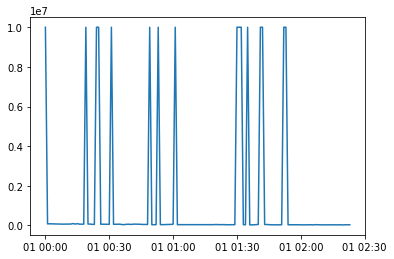

In [15]:
plt.plot(df['datetime'].iloc[:144], df['sw_plasma_temp'].iloc[:144])

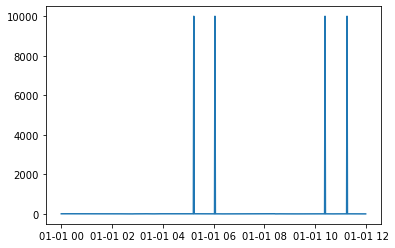

In [16]:
plt.plot(df['datetime'].iloc[:720], df['bz'].iloc[:720])

Bad values are the same across the magnetic field values, and are slightly different for other quantities.

In [17]:
print(max(df['scalar_b']), max(df['bx']), max(df['by']), max(df['bz']), max(df['sw_plasma_density']))

9999.990234375 9999.990234375 9999.990234375 9999.990234375 999.989990234375


In [18]:
print(min(df['scalar_b']), min(df['bx']), min(df['by']), min(df['bz']), min(df['sw_plasma_density']))

0.25999999046325684 -24.399999618530273 -35.279998779296875 -47.95000076293945 0.1599999964237213


Examination also tells us that the GPI values do not suffer from bad values.

In [19]:
print(min(df['f10_7']), min(df['Kp']), min(df['ap']), min(df['AE']))

83.4000015258789 0 0 6


In [20]:
print(max(df['f10_7']), max(df['Kp']), max(df['ap']), max(df['AE']))

275.3999938964844 90 400 4192


We'll fix these bad values by simple linear interpolation. For starts, let's swap them out with numpy NaNs so that they're easily identifiable.

In [21]:
df.replace([max(df['scalar_b']), max(df['sw_plasma_density']), 
                                     max(df['sw_plasma_temp']), max(df['sw_plasma_speed'])], np.nan, inplace=True)
df.head()

,datetime,scalar_b,bx,by,bz,sw_plasma_temp,sw_plasma_density,sw_plasma_speed,Kp,ap,f10_7,AE
0,2003-01-01 00:00:00,6.26,-5.00,3.33,1.74,NaN,NaN,NaN,10,4,111.199997,30
1,2003-01-01 00:01:00,6.27,-5.06,3.35,1.52,80463.0,5.82,410.299988,10,4,111.199997,26
2,2003-01-01 00:02:00,6.26,-5.22,3.08,1.51,85460.0,5.49,408.299988,10,4,111.199997,24
3,2003-01-01 00:03:00,6.26,-5.10,3.33,1.44,81797.0,5.67,410.200012,10,4,111.199997,23
4,2003-01-01 00:04:00,6.24,-5.11,3.05,1.83,77422.0,6.15,409.399994,10,4,111.199997,19


In [22]:
# Fix via interpolation
df['scalar_b'] = df['scalar_b'].interpolate()
df['bx'] = df['bx'].interpolate()
df['by'] = df['by'].interpolate()
df['bz'] = df['bz'].interpolate()

df['sw_plasma_density'] = df['sw_plasma_density'].interpolate()
df['sw_plasma_temp'] = df['sw_plasma_temp'].interpolate()
df['sw_plasma_speed'] = df['sw_plasma_speed'].interpolate()

Let's check that the values do look better

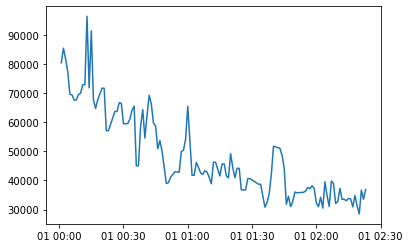

In [23]:
plt.plot(df['datetime'].iloc[:144], df['sw_plasma_temp'].iloc[:144])

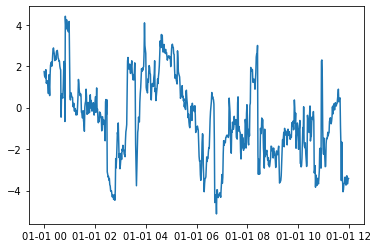

In [24]:
plt.plot(df['datetime'].iloc[:720], df['bz'].iloc[:720])

With the values squared away, we turn our attention to periods of interest. We're interested in isolating the 2003 Halloween storm period as our baseline

In [25]:
start_date = datetime.datetime(year=2003, month=10, day=25)
end_date = datetime.datetime(year=2003, month=11, day=8)

halloween_storm = df[df['datetime'].between(start_date, end_date, inclusive=True)]
halloween_storm.reset_index(drop=True, inplace=True)

/tmp/ipykernel_122019/216516989.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  halloween_storm = df[df['datetime'].between(start_date, end_date, inclusive=True)]


In [26]:
halloween_storm.head()

,datetime,scalar_b,bx,by,bz,sw_plasma_temp,sw_plasma_density,sw_plasma_speed,Kp,ap,f10_7,AE
0,2003-10-25 00:00:00,34.000000,1.82,0.89,33.939999,11694.0,5.95,565.000000,40,27,219.0,108
1,2003-10-25 00:01:00,33.990002,1.59,1.17,33.930000,11875.0,5.97,565.099976,40,27,219.0,110
2,2003-10-25 00:02:00,34.000000,1.40,1.50,33.939999,21790.0,7.44,570.000000,40,27,219.0,119
3,2003-10-25 00:03:00,34.060001,1.51,1.18,34.009998,8213.0,6.32,567.200012,40,27,219.0,120
4,2003-10-25 00:04:00,34.080002,1.58,1.03,34.029999,9183.0,6.03,567.900024,40,27,219.0,122


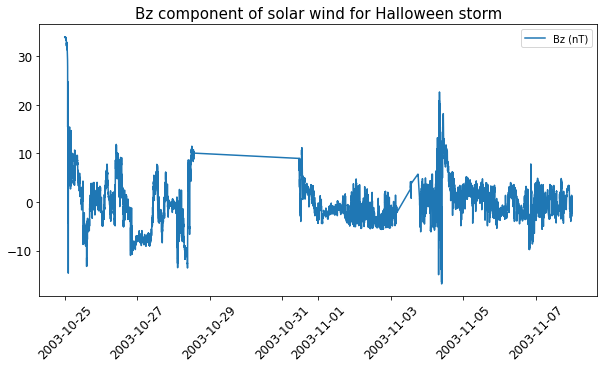

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(halloween_storm['datetime'], halloween_storm['bz'],label = 'Bz (nT)')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Bz component of solar wind for Halloween storm", fontsize=15)
plt.legend()

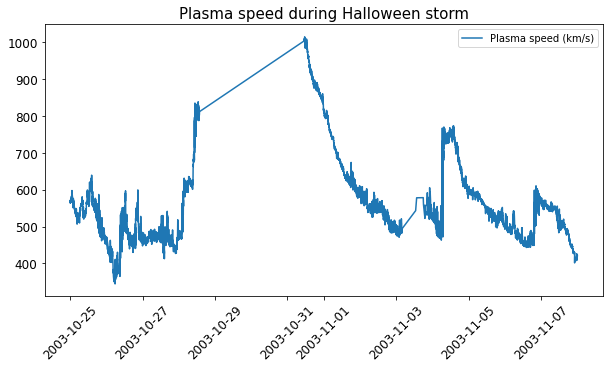

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(halloween_storm['datetime'], halloween_storm['sw_plasma_speed'],label = 'Plasma speed (km/s)')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Plasma speed during Halloween storm", fontsize=15)
plt.legend()

This still leaves some work to be desired. Let's pull in the hourly averages and try to superimpose them here

Refer to the 'Create Synthetic SW Data' notebook for comments

In [29]:
header_file = data_folder / "omni_2003_header.txt"
data_file = data_folder / "omni_2003.asc"
# Reader header info into a list
header_info = []
with open(header_file, 'r') as f:
    lines = f.readlines()

header_info = [x.strip().split()[1] for x in lines[4:]]
df_hourly = pd.read_fwf(data_file, names=header_info, infer_nrows = 8760, index_col=False, index=False)
df_hourly["datetime"] = pd.to_datetime(df_hourly['YEAR'] * 100000 + 100*df_hourly['DOY']+df_hourly['Hour'], format='%Y%j%H')
new_index = ['datetime'] + df_hourly.keys().tolist()[3:-1]
df_hourly = df_hourly[new_index]
df_hourly.head()

,datetime,Scalar_B,BX,BY,BZ,SW_Plasma_Temperature,SW_Proton_Density,SW_Plasma_Speed,Kp,ap_index,f10.7_index,AE-index
0,2003-01-01 00:00:00,6.5,-5.0,2.8,2.8,54536.0,4.8,407.0,10,4,111.2,25
1,2003-01-01 01:00:00,6.6,-0.1,6.2,1.2,59202.0,6.0,435.0,10,4,111.2,38
2,2003-01-01 02:00:00,6.9,-1.7,4.7,-2.6,52149.0,5.7,418.0,10,4,111.2,60
3,2003-01-01 03:00:00,6.8,1.9,5.8,0.6,37783.0,5.0,433.0,23,9,111.2,96
4,2003-01-01 04:00:00,7.0,2.0,6.3,2.1,42290.0,6.0,430.0,23,9,111.2,83


In [30]:
start_date = datetime.datetime(year=2003, month=10, day=25)
end_date = datetime.datetime(year=2003, month=11, day=8)

halloween_storm_hourly = df_hourly[df_hourly['datetime'].between(start_date, end_date, inclusive=True)]

/tmp/ipykernel_122019/4291171308.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  halloween_storm_hourly = df_hourly[df_hourly['datetime'].between(start_date, end_date, inclusive=True)]


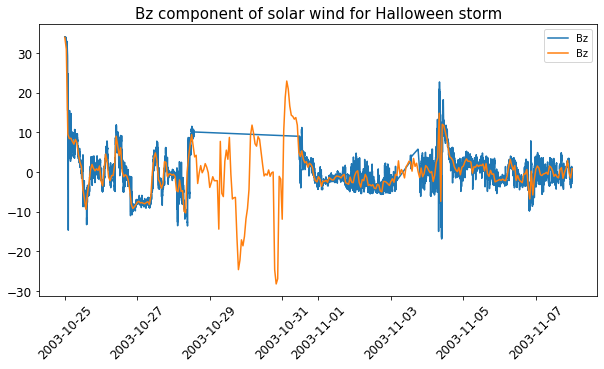

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(halloween_storm['datetime'], halloween_storm['bz'],label = 'Bz')
plt.plot(halloween_storm_hourly['datetime'], halloween_storm_hourly['BZ'],label = 'Bz')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Bz component of solar wind for Halloween storm", fontsize=15)
plt.legend()

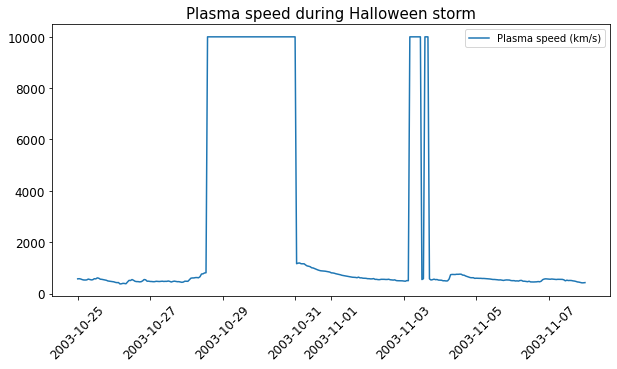

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(halloween_storm_hourly['datetime'], halloween_storm_hourly['SW_Plasma_Speed'],label = 'Plasma speed (km/s)')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Plasma speed during Halloween storm", fontsize=15)
plt.legend()

This looks promising. Let's merge left on our original dataframe, interpolate the hourly values to a minute time resolution, and then average them. We also drop the gpi from the hourly dataframe

In [33]:
halloween_storm_hourly.drop(['Kp', 'ap_index', 'f10.7_index', 'AE-index'], axis=1, inplace=True)

/tmp/ipykernel_122019/1474780628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  halloween_storm_hourly.drop(['Kp', 'ap_index', 'f10.7_index', 'AE-index'], axis=1, inplace=True)


In [34]:
halloween_storm_hourly.head()

,datetime,Scalar_B,BX,BY,BZ,SW_Plasma_Temperature,SW_Proton_Density,SW_Plasma_Speed
7128,2003-10-25 00:00:00,34.0,1.9,0.6,33.9,15624.0,5.8,571.0
7129,2003-10-25 01:00:00,32.7,-0.6,-7.3,30.9,44170.0,9.6,577.0
7130,2003-10-25 02:00:00,18.8,-2.0,-12.2,9.5,284291.0,28.6,565.0
7131,2003-10-25 03:00:00,14.7,-8.5,3.3,8.4,303546.0,29.8,541.0
7132,2003-10-25 04:00:00,14.2,-3.3,-8.5,8.5,349135.0,19.4,527.0


In [35]:
halloween_storm = halloween_storm.merge(halloween_storm_hourly, how='left')
halloween_storm.head()

,datetime,scalar_b,bx,by,bz,sw_plasma_temp,sw_plasma_density,sw_plasma_speed,Kp,ap,f10_7,AE,Scalar_B,BX,BY,BZ,SW_Plasma_Temperature,SW_Proton_Density,SW_Plasma_Speed
0,2003-10-25 00:00:00,34.000000,1.82,0.89,33.939999,11694.0,5.95,565.000000,40,27,219.0,108,34.0,1.9,0.6,33.9,15624.0,5.8,571.0
1,2003-10-25 00:01:00,33.990002,1.59,1.17,33.930000,11875.0,5.97,565.099976,40,27,219.0,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-10-25 00:02:00,34.000000,1.40,1.50,33.939999,21790.0,7.44,570.000000,40,27,219.0,119,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-10-25 00:03:00,34.060001,1.51,1.18,34.009998,8213.0,6.32,567.200012,40,27,219.0,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-10-25 00:04:00,34.080002,1.58,1.03,34.029999,9183.0,6.03,567.900024,40,27,219.0,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
halloween_storm['Scalar_B'] = halloween_storm['Scalar_B'].interpolate()
halloween_storm['BX'] = halloween_storm['BX'].interpolate()
halloween_storm['BY'] = halloween_storm['BY'].interpolate()
halloween_storm['BZ'] = halloween_storm['BZ'].interpolate()

halloween_storm['SW_Proton_Density'] = halloween_storm['SW_Proton_Density'].interpolate()
halloween_storm['SW_Plasma_Temperature'] = halloween_storm['SW_Plasma_Temperature'].interpolate()
halloween_storm['SW_Plasma_Speed'] = halloween_storm['SW_Plasma_Speed'].interpolate()

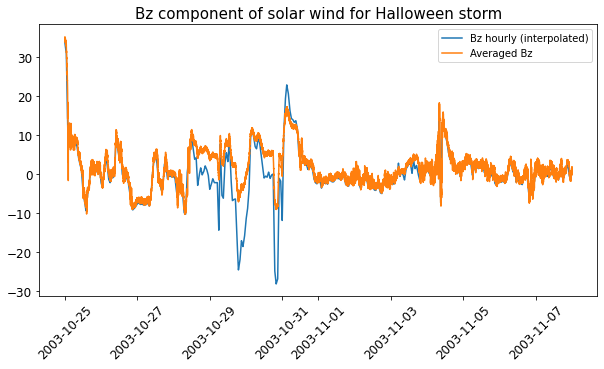

In [37]:
plt.figure(figsize=(10, 5))

# We add some gaussian noise to the averaged value
bz_test = 0.5*(halloween_storm['bz'] + halloween_storm['BZ']) 
mean, std_dev = np.mean(bz_test), np.std(bz_test)
bz_test += np.random.normal(mean, 0.05*std_dev, len(bz_test))

plt.plot(halloween_storm['datetime'], halloween_storm['BZ'],label = 'Bz hourly (interpolated)')
plt.plot(halloween_storm['datetime'], bz_test, label = 'Averaged Bz')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Bz component of solar wind for Halloween storm", fontsize=15)
plt.legend()

That looks more realisitic. Let's incorporate this information into our dataframe and drop the unnecessary columns

In [38]:
# Bx
bx = 0.5*(halloween_storm['bx'] + halloween_storm['BX']) 
mean, std_dev = np.mean(bx), np.std(bx)
bx += np.random.normal(mean, 0.05*std_dev, len(bx))

halloween_storm['bx'] = bx

# By
by = 0.5*(halloween_storm['by'] + halloween_storm['BY']) 
mean, std_dev = np.mean(by), np.std(by)
by += np.random.normal(mean, 0.05*std_dev, len(by))

halloween_storm['by'] = by

# Bz
bz = 0.5*(halloween_storm['bz'] + halloween_storm['BZ']) 
mean, std_dev = np.mean(bz), np.std(bz)
bz += np.random.normal(mean, 0.05*std_dev, len(bz))

halloween_storm['bz'] = bz

# Scalar B
# Derive from components for consistency

halloween_storm['scalar_b'] = np.sqrt(bx**2 + by**2 + bz**2)

# Temperature
sw_plasma_temp = 0.5*(halloween_storm['sw_plasma_temp'] + halloween_storm['SW_Plasma_Temperature']) 
mean, std_dev = np.mean(sw_plasma_temp), np.std(sw_plasma_temp)
sw_plasma_temp += np.random.normal(mean, 0.05*std_dev, len(sw_plasma_temp))

halloween_storm['sw_plasma_temp'] = sw_plasma_temp

# Density
sw_plasma_density = 0.5*(halloween_storm['sw_plasma_density'] + halloween_storm['SW_Proton_Density']) 
mean, std_dev = np.mean(sw_plasma_density), np.std(sw_plasma_density)
sw_plasma_density += np.random.normal(mean, 0.05*std_dev, len(sw_plasma_density))

halloween_storm['sw_plasma_density'] = sw_plasma_density

# Speed
sw_plasma_speed = 0.5*(halloween_storm['sw_plasma_speed'] + halloween_storm['SW_Plasma_Speed']) 
mean, std_dev = np.mean(sw_plasma_speed), np.std(sw_plasma_speed)
sw_plasma_speed += np.random.normal(mean, 0.05*std_dev, len(sw_plasma_speed))

halloween_storm['sw_plasma_speed'] = sw_plasma_speed

halloween_storm.drop(['BX', 'BY', 'BZ', 'SW_Plasma_Temperature', 'SW_Proton_Density', 'SW_Plasma_Speed'], axis=1, inplace=True)

In [39]:
halloween_storm.head()

,datetime,scalar_b,bx,by,bz,sw_plasma_temp,sw_plasma_density,sw_plasma_speed,Kp,ap,f10_7,AE,Scalar_B
0,2003-10-25 00:00:00,34.974384,3.464116,-2.937991,34.678173,1.202585e+06,112.022379,2154.923171,40,27,219.0,108,34.000000
1,2003-10-25 00:01:00,35.051192,3.946835,-3.002314,34.698626,1.003868e+06,126.871556,2125.002443,40,27,219.0,110,33.978333
2,2003-10-25 00:02:00,34.568801,3.396413,-3.051751,34.265919,1.282530e+06,140.483449,2079.241315,40,27,219.0,119,33.956667
3,2003-10-25 00:03:00,35.422035,3.929418,-3.252174,35.052869,1.331325e+06,131.625201,2137.216742,40,27,219.0,120,33.935000
4,2003-10-25 00:04:00,35.087936,3.797111,-3.371548,34.718552,1.209802e+06,141.060307,2307.138706,40,27,219.0,122,33.913333


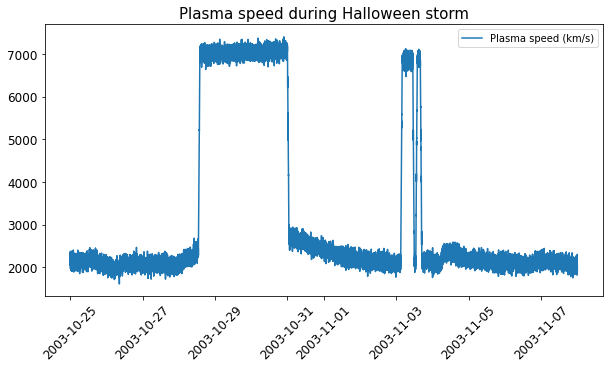

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(halloween_storm['datetime'], halloween_storm['sw_plasma_speed'],label = 'Plasma speed (km/s)')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Plasma speed during Halloween storm", fontsize=15)
plt.legend()

We now generate two additional dataframes, one enhanced and one diminished version of the storm

In [41]:
halloween_storm_plus = halloween_storm.copy()
halloween_storm_minus = halloween_storm.copy()

In [42]:
# Physical quantities we scale by a factor of 5
scaling_factor = 5
for key in ['bx', 'bx', 'bz', 'sw_plasma_temp', 'sw_plasma_density']:
        halloween_storm_plus[key] = scaling_factor*halloween_storm_plus[key] - np.nanmean(scaling_factor*halloween_storm_plus[key])


# These are indices, and do not the same ways as physical quantities.
# We arbitrarily scale them by 1.25
scaling_factor = 1.25
for key in ['Kp', 'ap', 'f10_7', 'AE']:
    halloween_storm_plus[key] = scaling_factor*halloween_storm_plus[key]

In [43]:
# Physical quantities we scale by a factor of .5
scaling_factor = .5
for key in ['bx', 'bx', 'bz', 'sw_plasma_temp', 'sw_plasma_density']:
        halloween_storm_minus[key] = scaling_factor*halloween_storm_minus[key] - np.nanmean(scaling_factor*halloween_storm_minus[key])


# These are indices, and do not the same ways as physical quantities.
# We arbitrarily scale them by 1.25
scaling_factor = .75
for key in ['Kp', 'ap', 'f10_7', 'AE']:
    halloween_storm_minus[key] = scaling_factor*halloween_storm_minus[key]

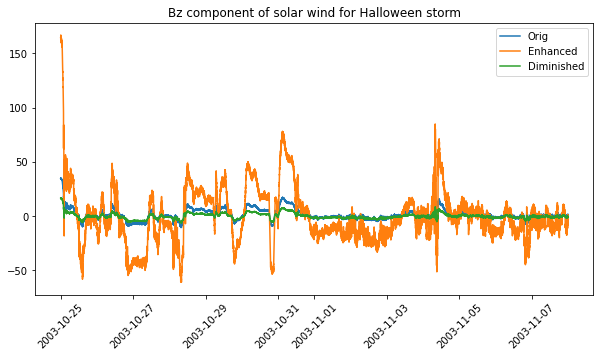

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(halloween_storm['datetime'], halloween_storm['bz'],label = 'Orig')
plt.plot(halloween_storm_plus['datetime'],halloween_storm_plus['bz'], label = 'Enhanced')
plt.plot(halloween_storm_minus['datetime'], halloween_storm_minus['bz'], label = 'Diminished')
plt.xticks(rotation=45)
plt.title("Bz component of solar wind for Halloween storm")
plt.legend()

Create netCDF files so that these datasets can be used

In [45]:
xr = xarray.Dataset.from_dataframe(halloween_storm)
xr['bx'].attrs={'units':'nT'}
xr['by'].attrs={'units':'nT'}
xr['bz'].attrs={'units':'nT'}
xr['scalar_b'].attrs={'units':'nT'}
xr['sw_plasma_temp'].attrs={'units':'K'}
xr['sw_plasma_density'].attrs={'units':'cm^-3'}
xr['ap'].attrs={'units':'nT'}
xr['AE'].attrs={'units':'nT'}
xr['f10_7'].attrs={'units':'sfu'}

xr.to_netcdf(data_folder / 'halloween_storm_1min.nc')

In [46]:
xr = xarray.Dataset.from_dataframe(halloween_storm_plus)
xr['bx'].attrs={'units':'nT'}
xr['by'].attrs={'units':'nT'}
xr['bz'].attrs={'units':'nT'}
xr['scalar_b'].attrs={'units':'nT'}
xr['sw_plasma_temp'].attrs={'units':'K'}
xr['sw_plasma_density'].attrs={'units':'cm^-3'}
xr['ap'].attrs={'units':'nT'}
xr['AE'].attrs={'units':'nT'}
xr['f10_7'].attrs={'units':'sfu'}


xr.to_netcdf(data_folder / 'halloween_storm_plus_1min.nc')

In [47]:
xr = xarray.Dataset.from_dataframe(halloween_storm_minus)
xr['bx'].attrs={'units':'nT'}
xr['by'].attrs={'units':'nT'}
xr['bz'].attrs={'units':'nT'}
xr['scalar_b'].attrs={'units':'nT'}
xr['sw_plasma_temp'].attrs={'units':'K'}
xr['sw_plasma_density'].attrs={'units':'cm^-3'}
xr['ap'].attrs={'units':'nT'}
xr['AE'].attrs={'units':'nT'}
xr['f10_7'].attrs={'units':'sfu'}


xr.to_netcdf(data_folder / 'halloween_storm_minus_1min.nc')